# Search for Questions with the same meaning

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
%matplotlib inline

In [3]:
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

In [84]:
df_train.head(1)

,id,qid1,qid2,question1,question2,is_duplicate,q1_num_sentences,q2_num_sentences,sentDiff,q1_num_words,q2_num_words,wordsDiff
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,0,14,12,2


In [4]:
df_train.dropna(0, how="any", inplace=True)

In [7]:
print('Total number of question pairs for training: {}'.format(len(df_train)))
print('Total number of question pairs for testing: {}'.format(len(df_test)))
print('Duplicate pairs: {}%'.format(round(df_train['is_duplicate'].mean()*100, 2)))

Total number of question pairs for training: 404290
Total number of question pairs for testing: 2345796
Duplicate pairs: 36.92%


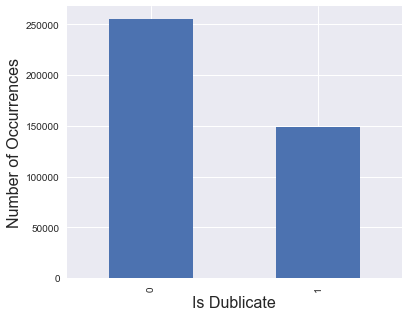

In [39]:
plt.figure(figsize=(6, 5))
df_train.is_duplicate.value_counts().plot(kind="bar")
plt.ylabel("Number of Occurrences", fontsize=16)
plt.xlabel("Is Dublicate", fontsize=16)
plt.show()

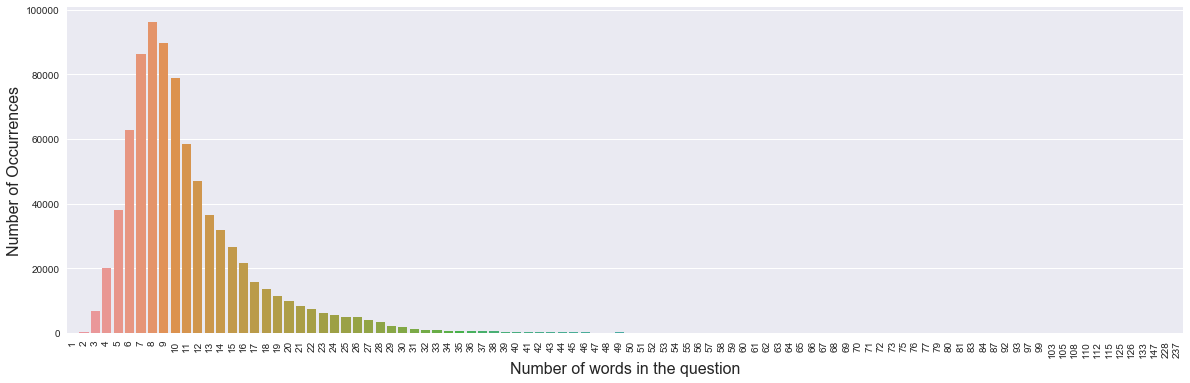

In [6]:
questions = pd.Series(df_train['question1'].apply(lambda x: len(x.split())).tolist() + df_train['question2'].apply(lambda x: len(x.split())).tolist())

plt.figure(figsize=(20,6))
sns.barplot(questions.value_counts().index, questions.value_counts().values)
plt.ylabel('Number of Occurrences', fontsize=16)
plt.xlabel('Number of words in the question', fontsize=16)
plt.xticks(rotation='vertical')
plt.show()

In [54]:
df_train["q1_num_words"] = df_train.question1.apply(lambda x: len(x.split()))
df_train["q2_num_words"] = df_train.question2.apply(lambda x: len(x.split()))
df_train["wordsDiff"] = df_train["q1_num_words"] - df_train["q2_num_words"]

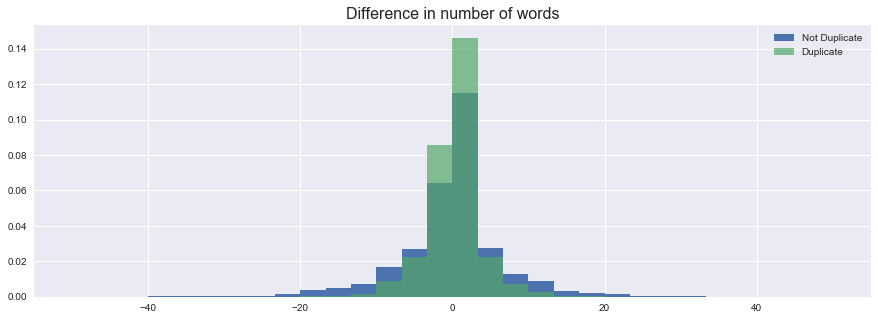

In [58]:
plt.figure(figsize=(15, 5))
plt.hist(df_train[df_train['is_duplicate'] == 0]["wordsDiff"], bins=30, normed=True, label='Not Duplicate', range=(-50, 50))
plt.hist(df_train[df_train['is_duplicate'] == 1]["wordsDiff"], bins=30, normed=True, alpha=0.7, label='Duplicate', range=(-50, 50))
plt.legend()
plt.title("Difference in number of words", fontsize=16)

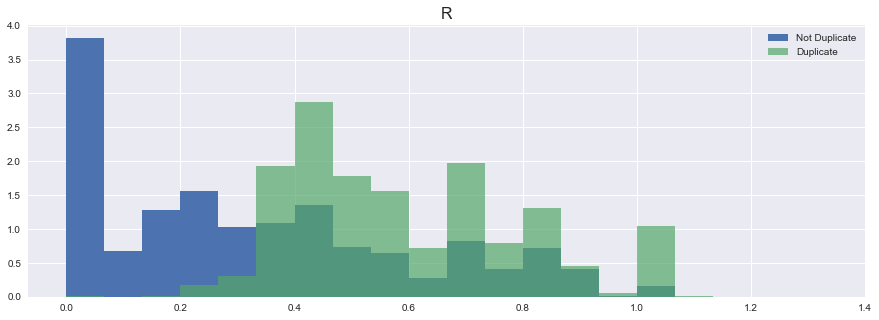

In [16]:
from nltk.corpus import stopwords

stops = set(stopwords.words("english"))

def word_match_share(row):
    q1words = []
    q2words = []
    for word in str(row['question1']).lower().split():
        if word not in stops:
            q1words.append(word)
    for word in str(row['question2']).lower().split():
        if word not in stops:
            q2words.append(word)
    if len(q1words) == 0 or len(q2words) == 0:
        return 0
    shared_words = [w for w in q1words if w in q2words]
    R = len(shared_words) * 2 /(len(q1words) + len(q2words))
    return R

plt.figure(figsize=(15, 5))
train_word_match = df_train.apply(word_match_share, axis=1, raw=True)
plt.hist(train_word_match[df_train['is_duplicate'] == 0], bins=20, normed=True, label='Not Duplicate')
plt.hist(train_word_match[df_train['is_duplicate'] == 1], bins=20, normed=True, alpha=0.7, label='Duplicate')
plt.legend()
plt.title('R', fontsize=16)

Этот признак хорош для определения того, что вопросы не являются дубликатами.

In [49]:
import re

df_train["q1_num_sentences"] = df_train.question1.apply(lambda x: len(list(filter(len, re.split("[\.|?|!|\.\.\.]", x)))))
df_train["q2_num_sentences"] = df_train.question2.apply(lambda x: len(list(filter(len, re.split("[\.|?|!|\.\.\.]", x)))))

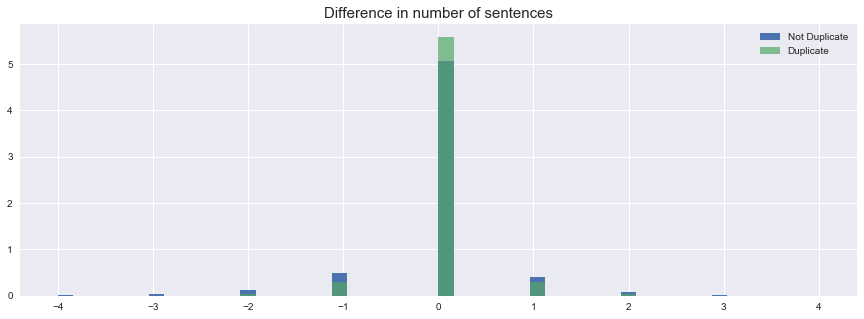

In [51]:
diff0 = df_train[df_train['is_duplicate'] == 0]["q1_num_sentences"] - df_train[df_train['is_duplicate'] == 0]["q2_num_sentences"]
diff1 = df_train[df_train['is_duplicate'] == 1]["q1_num_sentences"] - df_train[df_train['is_duplicate'] == 1]["q2_num_sentences"]
plt.figure(figsize=(15, 5))
plt.hist(diff0, bins=50, normed=True, label='Not Duplicate', range=(-4, 4))
plt.hist(diff1, bins=50, normed=True, alpha=0.7, label='Duplicate', range=(-4, 4))
plt.legend()
plt.title('Difference in number of sentences', fontsize=15)

In [51]:
df_train["sentDiff"] = df_train.q1_num_sentences - df_train.q2_num_sentences

In [85]:
import re

def clean_text(text):
    text = re.sub("\s", " ", text).lower()
    text = re.sub('[\'|"|)|(|}|{|+|*|~|\d|“|…]*', '', text)
    return list(filter(None, re.split('[ |.|,|;|:|/|!|?|—]', text)))

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer

corpus = df_train.question1.apply(lambda x: " ".join(clean_text(x))) + df_train.question2.apply(lambda x: " ".join(clean_text(x)))
vectorizer = TfidfVectorizer(stop_words='english').fit(corpus)

In [67]:
from scipy.sparse import coo_matrix, hstack

q1 = vectorizer.transform(df_train.question1.apply(lambda x: " ".join(clean_text(x))))
q2 = vectorizer.transform(df_train.question2.apply(lambda x: " ".join(clean_text(x))))
X = hstack([q1, q2, train_word_match.reshape((404288, 1))])
y = df_train.is_duplicate

/Users/Julia/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:5: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


In [68]:
from sklearn.cross_validation import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [77]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

lr = LogisticRegression(class_weight='balanced', max_iter=100)
lr.fit(x_train, y_train)
y_pred = lr.predict(x_test)
pred = clf.predict(x_test)
print(f1_score(y_test, y_pred, average='weighted'))
print(precision_score(y_test, y_pred, average='weighted'))
print(recall_score(y_test, y_pred, average='weighted'))

0.802156270745
0.809697778505
0.799722971135


In [46]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_jobs = 2, class_weight="balanced", max_depth = 80)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
f1_score(y_test, y_pred, average='weighted')

0.75246503962530986

In [71]:
from xgboost import XGBClassifier

model = XGBClassifier(max_depth = 10)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
f1_score(y_test, y_pred, average='weighted')

0.78074821296786945

In [73]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

params = {"alpha": np.arange(2, 10, 1)}
model = RidgeClassifier(class_weight="balanced", max_iter=150)
clf = GridSearchCV(model, params, scoring = "f1")
clf.fit(x_train, y_train)
pred = clf.predict(x_test)
print(clf.best_estimator_)
print(f1_score(y_test, pred, average='weighted'))
print(precision_score(y_test, pred, average='weighted'))
print(recall_score(y_test, pred, average='weighted'))

RidgeClassifier(alpha=4, class_weight='balanced', copy_X=True,
        fit_intercept=True, max_iter=150, normalize=False,
        random_state=None, solver='auto', tol=0.001)
0.802409812039
0.811582194633
0.799764195668


In [76]:
print(precision_score(y_test, pred, pos_label=1))
print(recall_score(y_test, pred, pos_label=1))
print(precision_score(y_test, pred, pos_label=0))
print(recall_score(y_test, pred, pos_label=0))

0.69473142465
0.815040923118
0.879825644751
0.790842246862
